# Introduction to Code Generation

This notebook exemplifies how to generate automatically code in terms of interfaces. For this three examples are provided. The first one creates a ROS message, the second a standard python class and the last a protobuf interface.

In [41]:
import capellambse

In [42]:
path_to_model = "../tests/data/melodymodel/5_0/Melody Model Test.aird"
model = capellambse.MelodyModel(path_to_model, jupyter_untrusted=True)

Cannot load PVMT extension: ValueError: Provided model does not have a PropertyValuePkg
Property values are not available in this model


In particular, we want to create code from our class:

Unknown global filter 'hide.technical.interfaces.filter'
Unknown global filter 'ModelExtensionFilter'
Unknown global filter 'hide.association.labels.filter'
No default style for 'Box.NumericType' in 'Class Diagram Blank'
No default style for 'Box.NumericType' in 'Class Diagram Blank'
No default style for 'Box.NumericType' in 'Class Diagram Blank'
No default style for 'Box.NumericType' in 'Class Diagram Blank'
No default style for 'Box.NumericType' in 'Class Diagram Blank'
No default style for 'Box.NumericType' in 'Class Diagram Blank'
No default style for 'Box.NumericType' in 'Class Diagram Blank'
No default style for 'Box.StringType' in 'Class Diagram Blank'
No default style for 'Box.StringType' in 'Class Diagram Blank'
No default style for 'Box.StringType' in 'Class Diagram Blank'
No default style for 'Box.StringType' in 'Class Diagram Blank'
No default style for 'Box.StringType' in 'Class Diagram Blank'
No default style for 'Box.StringType' in 'Class Diagram Blank'
No default style 

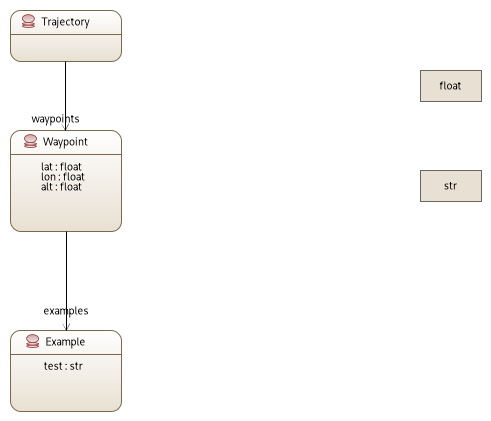

In [43]:
model.diagrams.by_name("[CDB] CodeGeneration")

In order to access the classes, we can simply access the `data_package` of the operational layer, and from there access the attribute `classes`.

In [44]:
data_pkg = model.oa.data_package
data_pkg.classes

<CoupledElementList at 0x0000027E19D07880 [<Class 'Twist' (8164ae8b-36d5-4502-a184-5ec064db4ec3)>, <Class 'Trajectory' (c5ea0585-7657-4764-9eb2-3a6584980ce6)>, <Class 'Waypoint' (2a923851-a4ca-4fd2-a4b3-302edb8ac178)>, <Class 'Example' (a7ecc231-c55e-4ab9-ae14-9558e3ec2a34)>]>

# ROS2 IDL Message

Let's have a brief look into the structure of ROS2 Message descriptions. They are stored in `.msg` files and comprised of a type and name, separated by whitespace, i.e.:

```
fieldtype1 fieldname1
fieldtype2[] fieldname2
```

In [45]:
def class_to_ros2_idl(cls):
    filename = f"{cls.name}.msg"
    lines = []
    for prop in cls.properties:
        multiplicity = ("", "[]")[prop.max_card.value > 1]
        lines.append(f"{prop.type.name}{multiplicity} {prop.name}")
    text = "\n".join(lines)
    with open(filename, "w") as file:
        file.write(text)
    print(f"# file: {filename} \n{text}\n")

In our example, files would be generated with the following content:

In [46]:
data_pkg = model.oa.data_package
for cls in data_pkg.classes:
    class_to_ros2_idl(cls)

# file: Twist.msg 


# file: Trajectory.msg 
Waypoint[] waypoints

# file: Waypoint.msg 
float lat
float lon
float alt
Example[] examples

# file: Example.msg 
str test



# Interface for python class

A python class has the following structure:


```
class class_name:
    name1: type  
    name2: [type]
```

A python interface can be generated as follows:

In [47]:
def class_to_python(cls, current_classes=None):
    lines = [f"class {cls.name}:"]
    current_classes = [cls]
    if not cls.properties:
        lines.append(4*" " + "pass")
    for prop in cls.properties:
        if (
            isinstance(
                prop.type, capellambse.model.crosslayer.information.Class
            )
            and prop.type not in current_classes
        ):
            nested_text = class_to_python(prop.type, current_classes)
            lines = [nested_text] + ["\n"] + lines
        multiplicity = (f"{prop.type.name}", f"list[{prop.type.name}]")[
            prop.max_card.value > 1
        ]
        lines.append(4*" " + f"{prop.name}: {multiplicity}")
    text = "\n".join(lines)

    return text

In [48]:
trajectory = data_pkg.classes.by_name("Trajectory")
text = class_to_python(trajectory)
filename = f"{trajectory.name.lower()}.py"
with open(filename, "w") as file:
    file.write(text)
print(f"# file: {filename} \n{text}\n")

# file: trajectory.py 
class Example:
    test: str


class Waypoint:
    lat: float
    lon: float
    alt: float
    examples: list[Example]


class Trajectory:
    waypoints: list[Waypoint]



# Interface for Protocol Buffers (Protobuf) 

Protobuf Message descriptions are stored in `.proto` files where a class definition starts with `message` and each property of the class is defined by at least three parts: the data type, name and its order number. Classes can also be nested in other classes. An example is shown in the following:


```
syntax = "proto3";

message class1 {
    datatype class1_name1 = 1;
    datatype class1_name2 = 2;
    message class2 {
        datatype class2_name1 = 1;
   }
   repeated class2 class_name = 3;
}

```


In [49]:
def class_to_proto(cls, current_classes=None, indent=""):
    if current_classes is None:
        current_classes = [cls]
        lines = ['syntax = "proto3";\n']
        indent += " "*4
        lines.append(f"{indent[:-4]}message  {cls.name} {{")
    else:
        lines = [f"{indent[:-4]}message  {cls.name} {{"]

    for counter, prop in enumerate(cls.properties, start=1):
        multiplicity = ("", "[]")[prop.max_card.value > 1]
        if (
            isinstance(
                prop.type, capellambse.model.crosslayer.information.Class
            )
            and prop.type not in current_classes
        ):
            current_classes.append(prop.type)
            nested_text = class_to_proto(
                prop.type, current_classes, indent + " "*4
            )
            lines.append(nested_text)
            lines.append(
                f"{indent}repeated {prop.type.name}{multiplicity} {prop.name} = {counter};"
            )
        else:
            lines.append(
                f"{indent}{prop.type.name}{multiplicity} {prop.name} = {counter};"
            )
    lines.append(f"{indent[:-4]}}}")
    text = "\n".join(lines)
    return text

The protobuf interface of class `Trajectory` would look as follows:


In [66]:
trajectory = data_pkg.classes.by_name("Trajectory")
text = class_to_proto(trajectory)
filename = f"{trajectory.name}.proto"
with open(filename, "w") as file:
    file.write(text)
print(f"# file: {filename} \n{text}\n")

AttributeError: 'str' object has no attribute 'append'